In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import tensorflow.keras.utils as utils
from tensorflow import keras
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [20]:
jobseeker = pd.read_csv('/content/jobseeker.csv')
jobseeker.head(5)

,id,nama,alamat,pendidikan,pengalaman,pengalaman_tahun,keterampilan,peminatan
0,1,Devi Laksita,KABUPATEN BATU BARA,SMP,Retail dan Dagang,3,Inovasi,Pariwisata
1,2,Maryadi Damanik,KABUPATEN ACEH TIMUR,SD,Freelance,3,Komunikasi,Pekerjaan Lepas
2,3,Harsana Puspasari,KABUPATEN BANTUL,SMP,Teknologi,3,Pemasaran,Tidak Ada Pengalaman
3,4,Banawi Pratiwi,KABUPATEN ENREKANG,SMP,Retail dan Dagang,3,Teknologi Informasi,Teknik
4,5,Karen Waskita,KABUPATEN PUNCAK,S1/D4,Pekerjaan Lepas,2,Adaptasi,Teknik


In [21]:
#menghapus spasi di depan kolom
jobseeker.columns = jobseeker.columns.str.strip()

In [22]:
# Fungsi untuk menentukan nilai label berdasarkan peminatan dan keterampilan
def assign_label(row):
    if row['peminatan'] in ['Freelance', 'Pariwisata', 'Retail dan Dagang', 'Teknologi'] and row['keterampilan'] in ['Mengembangkan Jaringan', 'Pemasaran', 'Penjualan', 'Kepemimpinan', 'Pemasaran']:
        return 'Pelayanan'
    elif row['peminatan'] in ['Pariwisata', 'Freelance', 'Teknik'] and row['keterampilan'] in ['Inovasi', 'Komunikasi', 'Adaptasi', 'Kepemimpinan']:
        return 'Pariwisata'
    elif row['peminatan'] in ['Teknik', 'Teknologi', 'Retail dan Dagang', 'Teknologi'] and row['keterampilan'] in ['Adaptasi', 'Komunikasi', 'Pemasaran']:
        return 'Pekerja Lepas'
    elif row['peminatan'] in ['Teknologi', 'Teknik', 'Freelance'] and row['keterampilan'] in ['Mengembangkan Jaringan', 'Manajemen', 'Teknologi Informasi']:
        return 'Teknik'
    elif row['peminatan'] in ['Pekerjaan Lepas', 'Pelayanan'] and row['keterampilan'] in ['Adaptasi', 'Manajemen']:
        return 'Freelance'
    elif row['peminatan'] == ['Tidak Ada Pengalaman', 'Pariwisata', ] and row['keterampilan'] in ['Adaptasi', 'Komunikasi',]:
        return 'Pariwisata'
    elif row['peminatan'] in ['Pekerja Lepas', 'Tidak Ada Pengalaman', 'Freelance'] and row['keterampilan'] in ['Keuangan', 'Manajemen', 'Adaptasi', 'Pemasaran']:
        return 'Retail dan Dagang'
    else:
        return 'Teknologi'

# Tambahkan kolom label berdasarkan kriteria
jobseeker['label'] = jobseeker.apply(assign_label, axis=1)

# Tampilkan dataset dengan kolom label baru
print(jobseeker)


       id                 nama                    alamat pendidikan  \
0       1         Devi Laksita       KABUPATEN BATU BARA        SMP   
1       2      Maryadi Damanik      KABUPATEN ACEH TIMUR         SD   
2       3    Harsana Puspasari          KABUPATEN BANTUL        SMP   
3       4       Banawi Pratiwi        KABUPATEN ENREKANG        SMP   
4       5        Karen Waskita          KABUPATEN PUNCAK      S1/D4   
..    ...                  ...                       ...        ...   
995   996     Among Laksmiwati       KABUPATEN MANOKWARI         SD   
996   997       Galih Dongoran    KABUPATEN SUMBA TENGAH    SMA/SMK   
997   998  Bakianto Zulkarnain  KABUPATEN SORONG SELATAN        SMP   
998   999     Jaswadi Lazuardi    KABUPATEN LOMBOK BARAT        SMP   
999  1000     Nabila Oktaviani     KABUPATEN KULON PROGO         SD   

            pengalaman  pengalaman_tahun            keterampilan  \
0    Retail dan Dagang                 3                 Inovasi   
1          

In [32]:
# Load dataset iris
iris = load_iris()
features = iris.data
labels = iris.target

# Split dataset menjadi data latih dan data uji
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Definisikan model klasifikasi
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
model.fit(train_features, train_labels, epochs=10, batch_size=32)

# Evaluasi model pada data uji
predictions = model.predict(test_features)
predicted_labels = tf.argmax(predictions, axis=1)
accuracy = accuracy_score(test_labels, predicted_labels)

# Print akurasi model
print("Akurasi model:", accuracy)

Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 1.1520 - accuracy: 0.3250
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 1.0200 - accuracy: 0.3833
Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.9363 - accuracy: 0.7000
Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8755 - accuracy: 0.7583
Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.8164 - accuracy: 0.9167
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7619 - accuracy: 0.7250
Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.7227 - accuracy: 0.6750
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.6750
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.6361 - accuracy: 0.8417
Epoch 10/10
1/1 [==============================] - 0s 63ms/step
Akurasi model: 0.9666666666666667


In [33]:
jobseeker.head(10)

,id,nama,alamat,pendidikan,pengalaman,pengalaman_tahun,keterampilan,peminatan,label,pendidikan_encoded
0,1,Devi Laksita,KABUPATEN BATU BARA,SMP,Retail dan Dagang,3,Inovasi,Pariwisata,Pariwisata,3
1,2,Maryadi Damanik,KABUPATEN ACEH TIMUR,SD,Freelance,3,Komunikasi,Pekerjaan Lepas,Teknologi,1
2,3,Harsana Puspasari,KABUPATEN BANTUL,SMP,Teknologi,3,Pemasaran,Tidak Ada Pengalaman,Retail dan Dagang,3
3,4,Banawi Pratiwi,KABUPATEN ENREKANG,SMP,Retail dan Dagang,3,Teknologi Informasi,Teknik,Teknik,3
4,5,Karen Waskita,KABUPATEN PUNCAK,S1/D4,Pekerjaan Lepas,2,Adaptasi,Teknik,Pariwisata,0
5,6,Cecep Nurdiyanti,KABUPATEN BUTON SELATAN,SMP,Pekerjaan Lepas,1,Komunikasi,Teknik,Pariwisata,3
6,7,Panca Saragih,KABUPATEN BANGKALAN,SMP,Teknologi,1,Manajemen,Pekerjaan Lepas,Freelance,3
7,8,Usman Narpati,KABUPATEN RAJA AMPAT,S1/D4,Teknik,2,Manajemen,Freelance,Teknik,0
8,9,Keisha Haryanti,KABUPATEN BEKASI,SMA/SMK,Teknologi,1,Kepemimpinan,Retail dan Dagang,Pelayanan,2
9,10,Mariadi Utama,KABUPATEN BUTON,SD,Retail dan Dagang,1,Keuangan,Freelance,Retail dan Dagang,1


In [34]:
# Menggunakan model untuk melakukan prediksi pada data uji
predictions = model.predict(test_features)

# Mengambil 3 prediksi teratas untuk setiap sampel
top_predictions = tf.argmax(predictions, axis=1)

# Menampilkan 3 prediksi teratas
for i in range(3):
    sample_index = i  # Ganti dengan indeks sampel yang ingin ditampilkan
    predicted_label = top_predictions[sample_index]
    print("Prediksi teratas untuk sampel ke-", sample_index+1, ":", predicted_label)

1/1 [==============================] - 0s 21ms/step
Prediksi teratas untuk sampel ke- 1 : tf.Tensor(1, shape=(), dtype=int64)
Prediksi teratas untuk sampel ke- 2 : tf.Tensor(0, shape=(), dtype=int64)
Prediksi teratas untuk sampel ke- 3 : tf.Tensor(2, shape=(), dtype=int64)


**EVALUASI **

---



In [35]:
# Memprediksi label pada data uji
predictions = model.predict(test_features)
predicted_labels = np.argmax(predictions, axis=1)

# Menghitung akurasi
accuracy = accuracy_score(test_labels, predicted_labels)

# Menghitung presisi
precision = precision_score(test_labels, predicted_labels, average='weighted')

# Menghitung recall
recall = recall_score(test_labels, predicted_labels, average='weighted')

# Menghitung F1-score
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Cetak hasil evaluasi
print("Akurasi:", accuracy)
print("Presisi:", precision)
print("Recall:", recall)
print("F1-score:", f1)


1/1 [==============================] - 0s 27ms/step
Akurasi: 0.9666666666666667
Presisi: 0.9694444444444444
Recall: 0.9666666666666667
F1-score: 0.9664109121909632


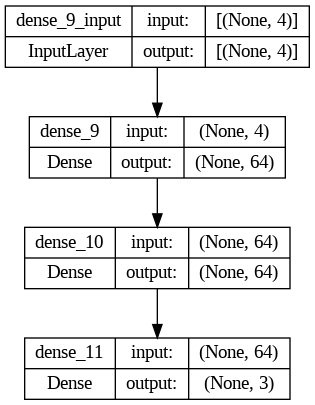

In [36]:
# Visualisasi arsitektur model Sequential
utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)

Epoch 1/10
4/4 [==============================] - 0s 65ms/step - loss: 0.5579 - accuracy: 0.9250 - val_loss: 0.5271 - val_accuracy: 0.9000
Epoch 2/10
4/4 [==============================] - 0s 12ms/step - loss: 0.5250 - accuracy: 0.9333 - val_loss: 0.4964 - val_accuracy: 0.9333
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.4943 - accuracy: 0.9333 - val_loss: 0.4697 - val_accuracy: 0.9667
Epoch 4/10
4/4 [==============================] - 0s 11ms/step - loss: 0.4690 - accuracy: 0.9583 - val_loss: 0.4459 - val_accuracy: 0.9667
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.4405 - accuracy: 0.9583 - val_loss: 0.4172 - val_accuracy: 0.9667
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.4142 - accuracy: 0.9417 - val_loss: 0.3954 - val_accuracy: 0.9667
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3936 - accuracy: 0.9667 - val_loss: 0.3793 - val_accuracy: 0.9667
Epoch 8/10
4/4 [===========

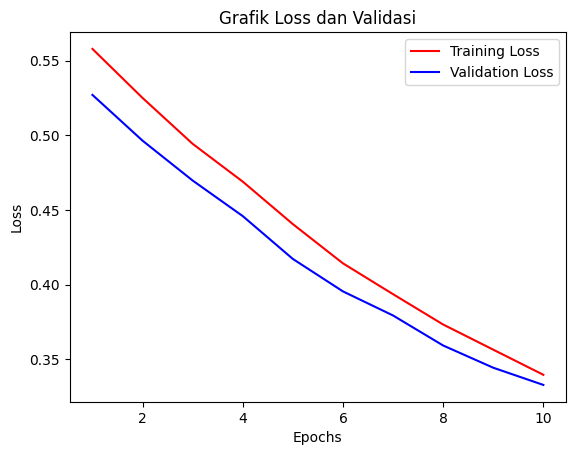

In [37]:
# Latih model dengan metrik validasi
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_data=(test_features, test_labels))

# Melihat grafik loss dan validasi
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Grafik Loss dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [38]:
# Menyimpan model dalam file pickle
filename = 'model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Mengambil model dari file pickle
loaded_model = pickle.load(open(filename, 'rb'))